# MMI splitter

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

import sys
sys.path.append('../../lib')
from ataitmeep import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Define the system
# parameters for 1220nm
sm_width = .35  # um
wavelength = 1.22  # um
fcen = 1 / wavelength
MMI_width = 2
reflector = True
MMI_length = 4.6 if reflector else 5.7
out_pitch = MMI_width / 1.78


cell = mp.Vector3(24, 8, 0)

background = mp.Block(mp.Vector3(cell.x, cell.y, 1e20),
                     center=mp.Vector3(0, 0),
                     material=mp.Medium(epsilon=3.9))
geometry = [background,
            mp.Block(mp.Vector3(cell.x / 2, sm_width, 1e20),
                     center=mp.Vector3(-cell.x / 4, 0),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(MMI_length, MMI_width, 1e20),
                     center=mp.Vector3(MMI_length / 2, 0),
                     material=mp.Medium(epsilon=12)),   
           ]

if reflector:
    geometry.extend([
                    mp.Prism([mp.Vector3(MMI_length, MMI_width / 2),
                              mp.Vector3(MMI_length, -MMI_width / 2),
                              mp.Vector3(MMI_length + MMI_width/2, 0),
                             ],
                             height=0, material=mp.Medium(epsilon=12)),
                    # This is the entry side
                    mp.Prism([mp.Vector3(0, MMI_width / 2),
                              mp.Vector3(0, -MMI_width / 2),
                              mp.Vector3(-MMI_width/4, 0),
                             ],
                             height=0, material=mp.Medium(epsilon=12)),
                    ])
        
else:
    geometry.extend([
                    mp.Block(mp.Vector3(cell.x / 2, sm_width, 1e20),
                             center=mp.Vector3(cell.x / 4, out_pitch / 2),
                             material=mp.Medium(epsilon=12)),
                    mp.Block(mp.Vector3(cell.x / 2, sm_width, 1e20),
                             center=mp.Vector3(cell.x / 4, -out_pitch / 2),
                             material=mp.Medium(epsilon=12)),
                    ])
    
dpml = 1.
pml_layers = [mp.PML(dpml)]

# this should be replaced by an eigenmode
# sources = [mp.Source(mp.ContinuousSource(frequency=fcen, width=2),
#                      component=mp.Ez,
#                      center=mp.Vector3(-cell.x / 2 + dpml, 0),
# #                      center=mp.Vector3(cell.x / 2 - dpml, out_pitch / 2),  # not working
#                      size=mp.Vector3(0, sm_width))]
df = fcen / 4
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                     component=mp.Ez,
                     center=mp.Vector3(-cell.x / 2 + dpml, 0), 
                     size=mp.Vector3(0, sm_width))]

resolution = 20

-----------
Initializing structure...
run 0 finished at t = 1.0 (40 timesteps)


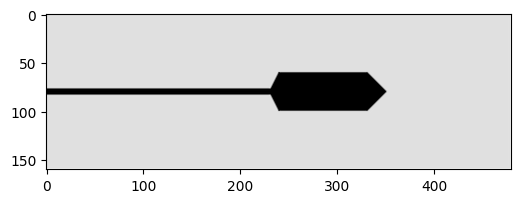

In [50]:
# Do the simulation, and verify the geometry
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=[mp.Mirror(mp.Y)],
                    progress_interval=1e6)

eps_data = show_geometry(sim)

run 1 finished at t = 160.0 (6400 timesteps)


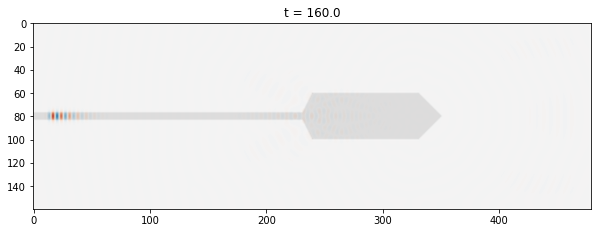

In [51]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(liveplot),
            mp.at_every(5, liveplot),
            mp.at_every(1, mp.output_png(mp.Ez, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
    subprocess.check_call(['convert', 'outputs/ez-*.png', 'ez.gif'])
    subprocess.check_call(['open', '-a', 'Safari', 'ez.gif'])

plt.figure(figsize=(10,6))
plot_sim(160)

field decay(t = 200.10000000000002): 3.654055967991629e-15 / 0.03506887449338367 = 1.0419655665541898e-13
run 0 finished at t = 200.10000000000002 (8004 timesteps)


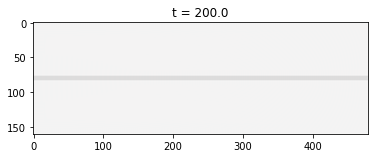

In [52]:
# Ok first do the straight waveguide
sim.reset_meep()
straight_geometry = [background,
                    mp.Block(mp.Vector3(cell.x, sm_width, 1e20),
                             center=mp.Vector3(0, 0),
                             material=mp.Medium(epsilon=12))]
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=straight_geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=[mp.Mirror(mp.Y)],
                    progress_interval=1e6)

# # Now put in some flux monitors. Make sure the pulse source was selected
nfreq = 100

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-cell.x / 2 + dpml + .5,0,0), size=mp.Vector3(0,2*sm_width,0))                            
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(cell.x / 2 - dpml, 0,0), size=mp.Vector3(0,2*sm_width,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Do it
monitor_pt = mp.Vector3(cell.x/2-dpml-0.5,0)
sim.run(mp.at_beginning(liveplot),
        mp.at_every(5, liveplot),    
        until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, monitor_pt,1e-5))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)
# transmission flux. Note this is entirely different purpose than the above line
# This one is to normalize power. the other was to negate forward-propagating wave
straight_tran_flux = mp.get_fluxes(tran)

field decay(t = 300.15000000000003): 1.1720102547708086e-07 / 0.0354336288969093 = 3.3076212943942564e-06
run 0 finished at t = 300.15000000000003 (12006 timesteps)


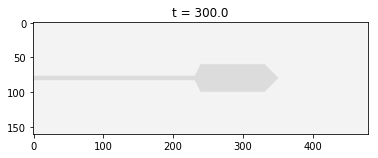

In [53]:
sim.reset_meep()
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    symmetries=[mp.Mirror(mp.Y)],
                    progress_interval=1e6)
# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

monitor_pt = mp.Vector3(-cell.x/2+dpml+0.5,0)
sim.run(mp.at_beginning(liveplot),
        mp.at_every(5, liveplot),    
        until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, monitor_pt,1e-5))

bend_refl_flux = mp.get_fluxes(refl)
flux_freqs = mp.get_flux_freqs(refl)

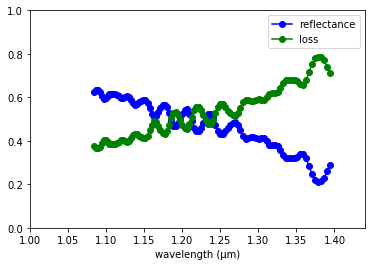

In [54]:
wl = []
Rs = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])

plt.plot(wl,Rs,'bo-',label='reflectance')
plt.plot(wl,1-Rs,'go-',label='loss')
plt.axis([1.0, 1.44, 0, 1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
